In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm


#Visualization
os.chdir('..')
import config as C
pd.set_option('display.max_columns', 40)
# events = pd.read_csv('data/BEPRO/2024/126285/events.csv')
# positions = pd.read_csv('data/BEPRO/2024/126285/positions.csv')
# teams = pd.read_csv('data/BEPRO/2024/126285/teams.csv')
# merged_df = merge_events_positions(events, positions)


In [ ]:
import re

traces_df = pd.read_csv('notebook/traces_df.csv')
traces_df['event_id'] = traces_df.index

In [3]:
traces_df.iloc[230:240,:][['timestamp','player_name','H08_x','H08_y']]

,timestamp,player_name,H08_x,H08_y
230,0 days 00:05:39.760000,Jinho Kim,8.142959,-17.208581
231,0 days 00:05:41.520000,Huigyun Lee,8.261415,-14.459838
232,0 days 00:05:44.680000,Jinho Kim,10.304551,-9.111247
233,0 days 00:05:46.040000,Alexandar Popovic,10.427655,-9.642421
234,0 days 00:05:47.200000,Alexandar Popovic,10.276000,-11.436200
235,0 days 00:05:48.480000,Youngkyu Ahn,10.213946,-14.380611
236,0 days 00:05:51.200000,Youngkyu Ahn,6.902500,-21.784600
237,0 days 00:05:52.120000,Kyongrok Choi,5.928908,-23.698503
238,0 days 00:05:53.120000,Kyongrok Choi,5.491615,-21.828246
239,0 days 00:05:53.520000,Kyongrok Choi,5.153576,-20.212799


In [4]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import pandas as pd

def visualize(index):
    row = traces_df.iloc[index]

    # 피치 좌표계: 왼쪽 아래가 (0,0)
    pitch = Pitch(pitch_type='custom',
                  pitch_length=105, pitch_width=68,
                  line_color='white',
                  axis=True,  # ✅ 축 표시
                  label=True,  # ✅ 축 눈금값 라벨 표시
                  pitch_color='grass',
                  stripe=True)
    fig, ax = pitch.draw()

    # 홈팀
    home_x, home_y = [], []
    for i in range(20):
        x, y = row.get(f'H{i:02}_x'), row.get(f'H{i:02}_y')
        if pd.notna(x) and pd.notna(y):
            x += 52.5
            y += 34
            home_x.append(x); home_y.append(y)
            pitch.annotate(str(i), (x, y), ax=ax,
                           va='center', ha='center', color='white', fontsize=10)
    pitch.scatter(home_x, home_y, ax=ax, color='blue', s=200, label='Home')

    # 어웨이팀
    away_x, away_y = [], []
    for i in range(20):
        x, y = row.get(f'A{i:02}_x'), row.get(f'A{i:02}_y')
        if pd.notna(x) and pd.notna(y):
            x += 52.5
            y += 34
            away_x.append(x); away_y.append(y)
            pitch.annotate(str(i), (x, y), ax=ax,
                           va='center', ha='center', color='white', fontsize=10)
    pitch.scatter(away_x, away_y, ax=ax, color='red', s=200, label='Away')

    # 공
    ball_x, ball_y = row['ball_x'] + 52.5, row['ball_y'] + 34
    pitch.scatter(ball_x, ball_y, ax=ax, color='yellow', s=100,
                  edgecolors='black', linewidth=1.0, label='Ball')

    # 시간 표시
    time_str = str(row['timestamp']).split(' ')[-1].split('.')[0]
    plt.title(f"Player Positions at {time_str}")
    plt.legend(loc='upper right')
    plt.show()


In [7]:
traces_df.iloc[230:240,:][['timestamp','player_name','H08_x','H08_y']]

,timestamp,player_name,H08_x,H08_y
230,0 days 00:05:39.760000,Jinho Kim,8.142959,-17.208581
231,0 days 00:05:41.520000,Huigyun Lee,8.261415,-14.459838
232,0 days 00:05:44.680000,Jinho Kim,10.304551,-9.111247
233,0 days 00:05:46.040000,Alexandar Popovic,10.427655,-9.642421
234,0 days 00:05:47.200000,Alexandar Popovic,10.276000,-11.436200
235,0 days 00:05:48.480000,Youngkyu Ahn,10.213946,-14.380611
236,0 days 00:05:51.200000,Youngkyu Ahn,6.902500,-21.784600
237,0 days 00:05:52.120000,Kyongrok Choi,5.928908,-23.698503
238,0 days 00:05:53.120000,Kyongrok Choi,5.491615,-21.828246
239,0 days 00:05:53.520000,Kyongrok Choi,5.153576,-20.212799


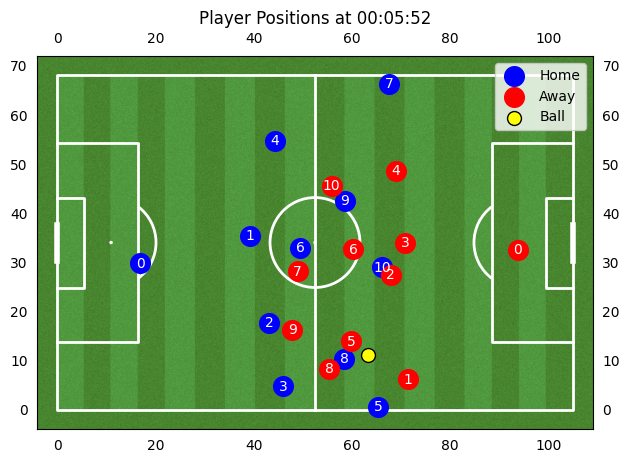

In [8]:
visualize(237)

1. Distance between the location of the ball and the center of the goal

In [ ]:
def distance_ball_goal(merged_df):
    goal_x = np.where(merged_df['attack_direction'] == 'RIGHT', C.PITCH_X_MAX, C.PITCH_X_MIN)
    goal_y = 0  # 양쪽 골대 y좌표는 동일
    dx = goal_x - merged_df['ball_x']
    dy = goal_y - merged_df['ball_y']
    distance = np.sqrt(dx**2 + dy**2)
    return pd.DataFrame({'distance_ball_goal' : distance},index=merged_df.index)



In [ ]:
distance_ball_goal(traces_df)

,distance_ball_goal
0,NaN
1,60.494538
2,61.078882
3,65.969671
4,66.563694
...,...
3913,72.495435
3914,70.086667
3915,70.014235
3916,74.807771


2. Distance between the location of the ball and the closest sideline

In [14]:
def distance_ball_sideline(merged_df):
    ball_sideline = np.minimum(merged_df['ball_y'] - C.PITCH_Y_MIN, C.PITCH_Y_MAX - merged_df['ball_y'])   
    
    return pd.DataFrame({'distance_ball_sideline' : ball_sideline },index=merged_df.index)


In [ ]:
distance_ball_sideline(traces_df)

,distance_ball_sideline
0,NaN
1,26.349036
2,27.026364
3,33.140139
4,32.733016
...,...
3913,10.464134
3914,6.814359
3915,6.618145
3916,0.001083


3. Distance between the location of the ball and the goalline


In [15]:
def distance_ball_goalline(merged_df):
    goaline_x = np.where(merged_df['attack_direction'] == 'RIGHT', C.PITCH_X_MIN, C.PITCH_X_MAX)
    ball_goaline = np.abs(goaline_x - merged_df['ball_x'])
    
    return pd.DataFrame({'distance_ball_goalline' : ball_goaline},index=merged_df.index)


In [16]:
distance_ball_goalline(traces_df)

,distance_ball_goalline
0,NaN
1,44.991235
2,44.320529
3,39.035933
4,38.448365
...,...
3913,36.431413
3914,40.400605
3915,40.562223
3916,38.364603


4. The speed of the player giving the pass

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_actor_speed(merged_df):
    actor_speeds = np.full(len(merged_df), np.nan)

    for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
        xID = row.player_code
        vx, vy = row.get(f"{xID}_vx", np.nan), row.get(f"{xID}_vy", np.nan)  # ← 오타 수정

        if pd.isna(vx) or pd.isna(vy):
            continue

        speed = np.sqrt(vx ** 2 + vy ** 2)  # ← np.sqrt(x^2 + y^2)
        actor_speeds[idx] = speed

    return pd.DataFrame({'actor_speed': actor_speeds}, index=merged_df.index)


In [ ]:
get_actor_speed(traces_df)

100%|██████████| 3918/3918 [00:00<00:00, 16601.62it/s]


,actor_speed
0,NaN
1,0.785471
2,1.002100
3,0.310956
4,1.837808
...,...
3913,6.961676
3914,2.869961
3915,7.171622
3916,1.121854


5. Angle between the location of the ball and the center of the goal

In [ ]:
import numpy as np

def angle_to_goal(merged_df):
    goal_x = np.where(merged_df['attack_direction'] == 'RIGHT', C.PITCH_X_MAX, C.PITCH_X_MIN)
    goal_y = 0  # 골대는 항상 중앙 y좌표

    dx = goal_x - merged_df['ball_x']
    dy = goal_y - merged_df['ball_y']
    angle = np.degrees(np.arctan2(dy, dx))

    return pd.DataFrame({'angle_to_goal' : angle },index=merged_df.index)


In [ ]:
traces_df[['ball_x','ball_y']]

,ball_x,ball_y
0,NaN,NaN
1,-7.508765,7.650964
2,-8.179471,6.973636
3,-13.464067,0.859861
4,-14.051635,-1.266984
...,...,...
3913,16.068587,23.535866
3914,12.099395,27.185641
3915,11.937777,27.381855
3916,14.135397,33.998917


In [ ]:
angle_to_goal(traces_df)

,angle_to_goal
0,NaN
1,-7.265864
2,-6.556000
3,-0.746825
4,1.090643
...,...
3913,-161.055442
3914,-157.176973
3915,-156.977671
3916,-152.968276


6. Time elapsed since the start of the game

In [ ]:
import pandas as pd
import numpy as np

def safe_to_timedelta(series: pd.Series) -> pd.Series:
    """
    모든 값을 Timedelta로 변환한다.
    """
    def _convert(x):
        if isinstance(x, pd.Timedelta):          # 그대로
            return x
        elif isinstance(x, pd.Timestamp):        # 날짜 → 그날 00:00 기준 경과
            return x - x.normalize()
        elif isinstance(x, str):                 # '0 days …' 같은 문자열
            try:
                return pd.to_timedelta(x)
            except ValueError:
                return pd.NaT
        else:
            return pd.NaT                        # 기타(숫자 등)

    return series.apply(_convert)


In [ ]:
def compute_time_elapsed(merged_df):
    # timestamp → timedelta 변환
    converted_timestamps = pd.to_timedelta(merged_df['timestamp'], errors='coerce')
    seconds = converted_timestamps.dt.total_seconds()

    # 전반 종료, 후반 시작 간 시간차 계산
    first_half_end = seconds[merged_df['period_id'] == 1].max()
    second_half_start = seconds[merged_df['period_id'] == 2].min()
    offset = first_half_end - second_half_start

    # 후반전만 offset 추가
    seconds_adjusted = seconds.copy()
    seconds_adjusted[merged_df['period_id'] == 2] += offset

    return pd.DataFrame({'elapsed_time': seconds_adjusted}, index=merged_df.index)


In [ ]:
compute_time_elapsed(traces_df)


,elapsed_time
0,1.52
1,2.32
2,3.12
3,4.12
4,5.32
...,...
3913,6079.04
3914,6079.48
3915,6079.52
3916,6083.24


7. Time elapsed since the last action of the defending team

In [ ]:
def time_since_last_opponent_action(merged_df) -> pd.Series:
    # 누적 시간 컬럼 계산
    merged_df = merged_df.copy()
    merged_df['elapsed_time'] = compute_time_elapsed(merged_df)

    result = []

    for idx, row in merged_df.iterrows():
        current_time = row['elapsed_time']
        current_team = row['tID']

        # 상대 팀 이벤트 중 현재 시간보다 이전 것만 필터링
        opponent_events = merged_df[(merged_df['tID'] != current_team) &
                                 (merged_df['elapsed_time'] < current_time)]

        if not opponent_events.empty:
            last_opponent_time = opponent_events['elapsed_time'].max()
            time_diff = current_time - last_opponent_time
        else:
            time_diff = 0.0

        result.append(time_diff)

    return pd.DataFrame({'time_since_last_opponent_action': result}, index=merged_df.index)



In [ ]:
time_since_last_opponent_action(traces_df)

,time_since_last_opponent_action
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
...,...
3913,0.24
3914,0.68
3915,0.72
3916,4.44


8,9. Number of goals scored by the defending/attacking team

In [ ]:
import ast
import pandas as pd
import numpy as np

def is_goal(qual_list):
    for d in qual_list:
        if (
            d.get('event_name') == 'Shots & Goals'
            and d.get('property', {}).get('Outcome') == 'Goals'
        ):
            return True
    return False

def cumul_goal(merged_df) -> pd.DataFrame:
    merged_df = merged_df.copy()
    merged_df['events'] = merged_df['events'].apply(ast.literal_eval)

    merged_df['is_goal'] = merged_df['events'].apply(is_goal)

    # 누적 골 초기화
    def_goal_count = np.zeros(len(merged_df), dtype=int)
    att_goal_count = np.zeros(len(merged_df), dtype=int)

    # 팀별로 누적 골 인덱싱
    for team in merged_df['tID'].unique():
        is_att = merged_df['tID'] == team
        is_def = ~is_att

        att_goal = merged_df['is_goal'] & is_att
        def_goal = merged_df['is_goal'] & is_def

        att_cumsum = att_goal.cumsum()
        def_cumsum = def_goal.cumsum()

        att_goal_count[is_att] = att_cumsum[is_att].shift(fill_value=0)
        def_goal_count[is_att] = def_cumsum[is_att].shift(fill_value=0)

    return pd.DataFrame({
        'def_goal_count': def_goal_count,
        'att_goal_count': att_goal_count
    }, index=merged_df.index)


In [ ]:
cumul_goal(traces_df)

,def_goal_count,att_goal_count
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
3913,0,2
3914,0,2
3915,0,2
3916,0,2


10. Goal difference

In [ ]:
def goaldiff(merged_df):
    df = cumul_goal(merged_df)
    df['goal_diff'] = df['att_goal_count'] - df['def_goal_count']
    return df[['goal_diff']]


In [ ]:
goaldiff(traces_df)

,goal_diff
0,0
1,0
2,0
3,0
4,0
...,...
3913,2
3914,2
3915,2
3916,2


11. Distance between the player giving the pass and his closest defender


In [17]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_closest_defender_info(merged_df):
    # 결과 저장 리스트
    ids, xs, ys, vxs, vys, speeds, dists = ([] for _ in range(7))

    for _, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
        ball_x, ball_y = row['ball_x'], row['ball_y']
        team_prefix   = row['player_code'][0]          # 'H' 또는 'A'
        defender_pref = 'A' if team_prefix == 'H' else 'H'

        candidates = []  # (x, y, vx, vy, id)

        for i in range(20):
            x = row.get(f"{defender_pref}{i:02}_x")
            y = row.get(f"{defender_pref}{i:02}_y")
            vx = row.get(f"{defender_pref}{i:02}_vx")
            vy = row.get(f"{defender_pref}{i:02}_vy")
            if pd.notna(x) and pd.notna(y):
                candidates.append((x, y, vx, vy, f"{defender_pref}{i:02}"))

        if candidates:
            arr = np.array([(c[0], c[1]) for c in candidates])        # (N,2)
            diff = arr - np.array([ball_x, ball_y])
            dist = np.linalg.norm(diff, axis=1)
            k = dist.argmin()

            x, y, vx, vy, pid = candidates[k]
            ids.append(pid)
            xs.append(x)
            ys.append(y)
            vxs.append(vx)
            vys.append(vy)
            speeds.append(np.hypot(vx, vy))
            dists.append(dist[k])
        else:
            ids.append(np.nan); xs.append(np.nan); ys.append(np.nan)
            vxs.append(np.nan); vys.append(np.nan); speeds.append(np.nan); dists.append(np.nan)

    # 결과 DataFrame (merged_df와 같은 index 사용)
    return pd.DataFrame({
        'closest_defender_id'   : ids,
        'closest_defender_x'    : xs,
        'closest_defender_y'    : ys,
        'closest_defender_vx'   : vxs,
        'closest_defender_vy'   : vys,
        'closest_defender_speed': speeds,
        'closest_defender_dist' : dists,
    }, index=merged_df.index)


In [ ]:
# --- 1. 최단 거리 수비수와의 거리 ---
def get_min_defender_distance(traces_df):
    # get_closest_defender_info 함수가 모든 정보를 반환하므로 한 번만 호출
    # merged_df는 원본 events와 positions가 병합된 상태 (디버깅이나 추가 분석에 유용)
    results_df = get_closest_defender_info(traces_df)
    
    # 결과를 담을 DataFrame은 이벤트의 인덱스를 따릅니다.
    return results_df[['closest_defender_dist']]
get_min_defender_distance(traces_df)

  0%|          | 0/3918 [00:00<?, ?it/s]

100%|██████████| 3918/3918 [00:01<00:00, 3336.41it/s]


,closest_defender_dist
0,NaN
1,4.854733
2,4.530013
3,8.544856
4,5.130444
...,...
3913,7.609506
3914,9.153265
3915,8.922244
3916,3.591806


In [ ]:
results_df

,closest_defender_id,closest_defender_x,closest_defender_y,closest_defender_vx,closest_defender_vy,closest_defender_speed,closest_defender_dist
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A07,-2.732579,8.520725,-0.990691,-0.736886,1.234694,4.854733
2,A07,-3.817496,8.196009,-1.608564,-0.323307,1.640733,4.530013
3,A09,-7.315443,-5.073856,-1.869153,1.573487,2.443275,8.544856
4,A09,-9.645124,-3.894553,-2.071624,-0.273977,2.089663,5.130444
...,...,...,...,...,...,...,...
3913,A12,16.758169,15.957670,-5.146011,2.695759,5.809350,7.609506
3914,A02,3.813872,23.295606,1.893273,6.144195,6.429278,9.153265
3915,A02,3.888013,23.533775,1.898296,5.989233,6.282869,8.922244
3916,A16,10.647739,33.140249,-3.623763,0.905759,3.735245,3.591806


12. Speed of the defender closest to the player giving the pass

In [ ]:
# --- 2. 최단 거리 수비수의 속도 ---
def get_closest_defender_speed(traces_df):
    results_df = get_closest_defender_info(traces_df) # 이미 계산된 정보를 활용
    return results_df[['closest_defender_speed']]
get_closest_defender_speed(traces_df)

100%|██████████| 3918/3918 [00:01<00:00, 3525.79it/s]


,closest_defender_speed
0,NaN
1,1.234694
2,1.640733
3,2.443275
4,2.089663
...,...
3913,5.809350
3914,6.429278
3915,6.282869
3916,3.735245


13. Difference in speed between the player giving the pass and his closest defender

In [ ]:
# --- 3. 행위자와 최단거리 수비수의 속도 차이 ---
def get_speed_diff_actor_defender(merged_df):
    results_df = get_closest_defender_info(merged_df)    

    actor_speeds_series = get_actor_speed(merged_df)['actor_speed']

    # 속도 차이 계산, closest_defender_speed는 results_df에 있습니다.
    speed_diff = actor_speeds_series - results_df['closest_defender_speed']
    
    return pd.DataFrame(speed_diff, columns=['speed_diff_actor_defender'], index=merged_df.index)


In [ ]:
get_speed_diff_actor_defender(traces_df)

100%|██████████| 3918/3918 [00:00<00:00, 19833.95it/s]


,speed_diff_actor_defender
0,NaN
1,-0.449223
2,-0.638633
3,-2.132319
4,-0.251855
...,...
3913,1.152326
3914,-3.559317
3915,0.888753
3916,-2.613391


14. Number of defenders in a 3 m radius around the ball

In [22]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def nb_of_m_radius(merged_df, dist=3.0):
    """행위자 기준 반경 dist m 안에 있는 상대편 선수 수를 반환한다."""
    # 미리 홈/어웨이 좌표 컬럼 목록을 만들어두면 루프 안에서 재생성하지 않아도 됨
    home_cols = [(f"H{i:02}_x", f"H{i:02}_y") for i in range(20)
                 if f"H{i:02}_x" in merged_df.columns and f"H{i:02}_y" in merged_df.columns]
    away_cols = [(f"A{i:02}_x", f"A{i:02}_y") for i in range(20)
                 if f"A{i:02}_x" in merged_df.columns and f"A{i:02}_y" in merged_df.columns]

    counts = []

    for _, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
        actor_team = row['player_code'][0]          # 'H' 또는 'A'
        opponent_cols = away_cols if actor_team == 'H' else home_cols

        ex, ey = row['ball_x'], row['ball_y']     # 이벤트 기준점

        cnt = 0
        for x_col, y_col in opponent_cols:
            px, py = row[x_col], row[y_col]
            if pd.notna(px) and pd.notna(py):
                if (px - ex) ** 2 + (py - ey) ** 2 <= dist ** 2:
                    cnt += 1
        counts.append(cnt)

    return pd.DataFrame({f'nb_of_{dist}m_radius': counts}, index=merged_df.index)


In [ ]:
nb_of_m_radius(traces_df, dist = 5)


100%|██████████| 3918/3918 [00:00<00:00, 8296.06it/s]


15. Number of defenders in a 5 m radius around the ball

In [ ]:
nb_of_m_radius(traces_df, dist = 5)

100%|██████████| 3918/3918 [00:00<00:00, 8325.29it/s]


,nb_of_5m_radius
0,0
1,1
2,1
3,0
4,0
...,...
3913,0
3914,0
3915,0
3916,1


16. Distance between the location of the defender closest to the ball and the nearest
sideline

In [ ]:
results_df

,closest_defender_id,closest_defender_x,closest_defender_y,closest_defender_vx,closest_defender_vy,closest_defender_speed,closest_defender_dist
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A07,-2.732579,8.520725,-0.990691,-0.736886,1.234694,4.854733
2,A07,-3.817496,8.196009,-1.608564,-0.323307,1.640733,4.530013
3,A09,-7.315443,-5.073856,-1.869153,1.573487,2.443275,8.544856
4,A09,-9.645124,-3.894553,-2.071624,-0.273977,2.089663,5.130444
...,...,...,...,...,...,...,...
3913,A12,16.758169,15.957670,-5.146011,2.695759,5.809350,7.609506
3914,A02,3.813872,23.295606,1.893273,6.144195,6.429278,9.153265
3915,A02,3.888013,23.533775,1.898296,5.989233,6.282869,8.922244
3916,A16,10.647739,33.140249,-3.623763,0.905759,3.735245,3.591806


In [ ]:
# --- 4. 공에 가장 가까운 수비수의 위치와 가장 가까운 터치라인 사이의 거리 ---
def get_dist_defender_to_sideline(merged_df):
    results_df = get_closest_defender_info(merged_df) # 최단거리 수비수 x, y 좌표 사용
       
    sideline_dist = np.minimum(results_df['closest_defender_y']-C.PITCH_Y_MIN, C.PITCH_Y_MAX - results_df['closest_defender_y'])
    return sideline_dist.to_frame(name='dist_defender_to_sideline')

get_dist_defender_to_sideline(traces_df)

100%|██████████| 3918/3918 [00:01<00:00, 3499.17it/s]


,dist_defender_to_sideline
0,NaN
1,25.479275
2,25.803991
3,28.926144
4,30.105447
...,...
3913,18.042330
3914,10.704394
3915,10.466225
3916,0.859751


17. Distance between the location of the defender closest to the ball and the goalline

In [ ]:
# --- 5. 공에 가장 가까운 수비수와 골라인 사이의 거리 ---
def get_dist_defender_to_goaline(merged_df):
    results_df = get_closest_defender_info(merged_df) # 최단거리 수비수 x, y 좌표 사용
    def_goal_x = np.where(merged_df['attack_direction'] == 'RIGHT', C.PITCH_X_MAX, C.PITCH_X_MIN)
    goaline_dist = np.abs(def_goal_x - results_df['closest_defender_x'])
    return goaline_dist.to_frame(name='dist_defender_to_goaline')

get_dist_defender_to_goaline(traces_df)

100%|██████████| 3918/3918 [00:01<00:00, 3505.47it/s]


,dist_defender_to_goaline
0,NaN
1,55.232579
2,56.317496
3,59.815443
4,62.145124
...,...
3913,69.258169
3914,56.313872
3915,56.388013
3916,63.147739


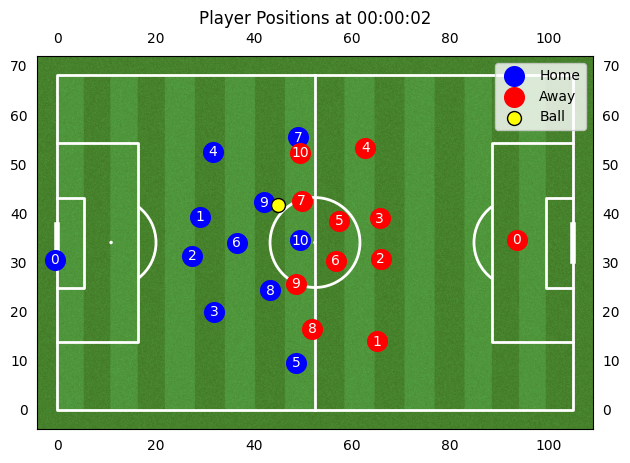

In [ ]:
visualize(1)

19. Difference in distance to the closest sideline between the location of the ball and the closest defender


In [20]:
# --- 6. (공에 가장 가까운 수비수와 사이드라인 사이의 거리, 공과 사이드라인 사이의 거리), 두 거리의 차이 ---
def get_diff_ball_defender_sideline(merged_df):
    results_df = get_closest_defender_info(merged_df)
    
    ball_y = merged_df['ball_y']
    defender_y = results_df['closest_defender_y']
    
    ball_to_sideline = np.minimum(ball_y - C.PITCH_Y_MIN, C.PITCH_Y_MAX - ball_y)
    defender_to_sideline = np.minimum(defender_y - C.PITCH_Y_MIN, C.PITCH_Y_MAX - defender_y)
    
    diff = ball_to_sideline - defender_to_sideline
    
    return pd.DataFrame(diff, columns=['diff_ball_defender_sideline'], index=merged_df.index)


get_diff_ball_defender_sideline(traces_df)

100%|██████████| 3918/3918 [00:01<00:00, 3830.28it/s]


,diff_ball_defender_sideline
0,NaN
1,0.869761
2,1.222373
3,4.213995
4,2.627569
...,...
3913,-7.578197
3914,-3.890035
3915,-3.848081
3916,-0.858668


20. Number of defenders in a 10 m radius around the ball 

In [24]:
nb_of_m_radius(traces_df, dist = 10)

100%|██████████| 3918/3918 [00:00<00:00, 8437.61it/s]


,nb_of_10m_radius
0,0
1,1
2,1
3,1
4,1
...,...
3913,2
3914,1
3915,1
3916,3


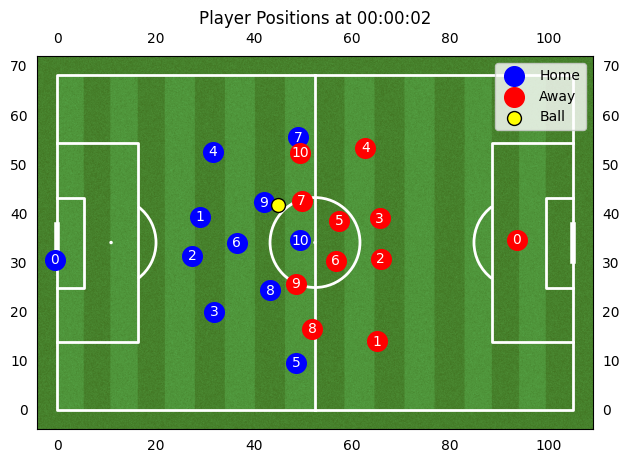

In [26]:
visualize(1)

In [116]:
os.getcwd()

'/home/exPress/express-v2'

21. Average pitch control in a 4 m radius around the location of the ball

In [ ]:
os.chdir('/home/exPress/express-v2')
import pitch_control as pc

/home/exPress


In [33]:
params = pc.default_model_params()
params

{'max_player_accel': 7.0,
 'max_player_speed': 5.0,
 'reaction_time': 0.7,
 'tti_sigma': 0.45,
 'kappa_def': 1,
 'lambda_att': 4.3,
 'lambda_def': 4.3,
 'lambda_gk': 12.899999999999999,
 'average_ball_speed': 15.0,
 'int_dt': 0.04,
 'max_int_time': 10,
 'model_converge_tol': 0.01,
 'time_to_control_att': 3.3202550055547313,
 'time_to_control_def': 3.3202550055547313}

In [ ]:
from matplotlib.colors import TwoSlopeNorm

# Generate Pitch Control for predictor models
def calculate_model_pitch_control(results_df, event_id):
    event_df = results_df[results_df["event_id"] == event_id].copy()

    # event_df["x"] = event_df["act_x"].copy()
    # event_df["y"] = event_df["act_y"].copy()

    i
    # event_df.loc[event_df["team_on_ball"] == False, "x"] = config.field_length - event_df.loc[event_df["team_on_ball"] == False, "x"].values
    # event_df.loc[event_df["team_on_ball"] == False, "y"] = config.field_width - event_df.loc[event_df["team_on_ball"] == False, "y"].values

    PPCFa, xgrid, ygrid = pc.generate_pitch_control_for_event(event_df.iloc[0], event_df, params, 
                                                       field_dimen=(C.PITCH_X_MAX-C.PITCH_X_MIN, C.PITCH_Y_MAX-C.PITCH_Y_MIN,), 
                                                       n_grid_cells_x=52, n_grid_cells_y=34, offsides=False, #52.2
    )
    
    fig, ax = pc.plot_pitchcontrol_for_event(PPCFa, event_df.iloc[0], event_df)
    fig.set_size_inches(12,8)

    return PPCFa, ax, event_df, xgrid, ygrid

def plot_pitchcontrol(event_id, PPCF, locs, alpha = 0.7, include_player_velocities=True, annotate=False, field_dimen = (105.0, 68)):
    #highlight = events[events["event_id"] == event_id].iloc[0]

    if False:
        cond = (locs["period_id"] == 1)
        locs.loc[cond, "x"] = (
            105 - locs.loc[cond, "x"].values
        )
        locs.loc[cond, "y"] = (
            68 - locs.loc[cond, "y"].values
        )
    
    row = {}
    for r in locs.itertuples():
        row[f"{r.key}_x"] = r.x
        row[f"{r.key}_y"] = r.y
    # row["B00_x"] = locs.iloc[0].ballx
    # row["B00_y"] = locs.iloc[0].bally
    trace = pd.DataFrame.from_dict(row, orient='index').T


    # 컬러바 생성
    # cbar = fig.colorbar(pc, orientation='vertical')
    # cbar.set_label('Probability')
    
    norm = TwoSlopeNorm(vmin=0.0, vcenter=0.5, vmax=np.max(PPCF))
    # pc = ax.imshow(np.flipud(PPCF), extent=(0, field_dimen[0], 0, field_dimen[1]),
    #             norm=norm, cmap='bwr', alpha=0.5)

    pc = ax.imshow(np.flipud(PPCF), extent=(0, field_dimen[0], 0, field_dimen[1]), 
                vmin=0.0, vmax=1.0, cmap='bwr', alpha=0.5)
    
    # for i in range(PPCF.shape[0]):
    #     for j in range(PPCF.shape[1]):
    #         val = PPCF[i, j]
    #         if val > 0.01:  # 너무 작은 값은 생략
    #             ax.text(
    #                 j * (field_dimen[0] / PPCF.shape[1]) + (field_dimen[0] / (2 * PPCF.shape[1])),  # x
    #                 i * (field_dimen[1] / PPCF.shape[0]) + (field_dimen[1] / (2 * PPCF.shape[0])),  # y
    #                 f"{val:.2f}",
    #                 color='black',
    #                 ha='center',
    #                 va='center',
    #                 fontsize=6,
    #                 alpha=0.8
    #             )
    norm = TwoSlopeNorm(vmin=0.0, vcenter=0.5, vmax=1.0)

    # pc = ax.imshow(np.flipud(PPCF), extent=(0, field_dimen[0], 0, field_dimen[1]),cmap='bwr',alpha=0.5, norm=norm)
    # cbar = fig.colorbar(pc, orientation='vertical')
    # cbar.set_label('Probability')

    return fig, ax

In [ ]:
teams = pd.read_csv('express-v2/notebook/teams.csv')
team_sheets_lookup = {
    row["tracking_id"]: {
        "player_id": row["player_id"],
        "team_id":   row["team_id"],
        "position":  row["position"],
        "team": row["team"]
    }
    for _, row in teams.iterrows()
}


In [75]:
melted = []
import re

tracking_ids = [col[:-2] for col in traces_df.columns if re.fullmatch(r'[HA]\d{2}_x', col)]
team_id_unique = traces_df['tID'].unique()
for i, row in enumerate(tqdm(traces_df.itertuples(), total=len(traces_df))):
    event_id = row.event_id
    period_id = row.period_id

    for base_id in tracking_ids:
        x = getattr(row, f"{base_id}_x", np.nan)
        y = getattr(row, f"{base_id}_y", np.nan)
        vx = getattr(row, f"{base_id}_vx", np.nan)
        vy = getattr(row, f"{base_id}_vy", np.nan)

        if pd.isna(x) or pd.isna(y):
            continue

        melted.append({
            "key": base_id,
            "period_id": period_id,
            "event_id": event_id,
            "team_id": team_sheets_lookup[base_id]["team_id"],
            "team_on_ball": row.player_code[0] == base_id[0],
            "player_on_ball": row.player_code == base_id ,
            "position": team_sheets_lookup[base_id]['position'],
            "x": x + C.PITCH_X_MAX,
            "y": y + C.PITCH_Y_MAX,
            "vx":vx,
            "vy":vy,
            "ballx": getattr(row, "ball_x", np.nan) + C.PITCH_X_MAX,
            "bally": getattr(row, "ball_y", np.nan) + C.PITCH_Y_MAX,
        })
melted_df = pd.DataFrame(melted)
melted_df

  0%|          | 0/3918 [00:00<?, ?it/s]

100%|██████████| 3918/3918 [00:00<00:00, 10454.54it/s]


,key,period_id,event_id,team_id,team_on_ball,player_on_ball,position,x,y,vx,vy,ballx,bally
0,A00,1,1,316,False,False,GK,93.532365,34.492724,-1.198613,0.404334,44.991235,41.650964
1,A01,1,1,316,False,False,LB,65.077211,13.890175,-0.462158,-0.211185,44.991235,41.650964
2,A02,1,1,316,False,False,CB,65.899502,30.725601,-1.800818,0.433549,44.991235,41.650964
3,A03,1,1,316,False,False,CB,65.635385,38.934649,-2.525410,0.666646,44.991235,41.650964
4,A04,1,1,316,False,False,RB,62.758282,53.284895,-0.294340,0.728068,44.991235,41.650964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85882,H13,2,3917,4648,False,False,CB,77.909400,50.957700,-0.173866,1.374191,66.920200,68.000000
85883,H14,2,3917,4648,False,False,LM,66.218000,24.082700,0.046329,0.004354,66.920200,68.000000
85884,H17,2,3917,4648,False,False,CM,70.098900,42.309600,0.828372,1.984355,66.920200,68.000000
85885,H18,2,3917,4648,False,False,CF,45.387000,45.513700,-1.031379,0.595588,66.920200,68.000000


/home/exPress/PlayerImputer/datatools/pitch_control.py:245: RuntimeWarning: divide by zero encountered in scalar divide
  checksum = np.sum( PPCFa + PPCFd ) / float(count)#float(n_grid_cells_y*n_grid_cells_x )


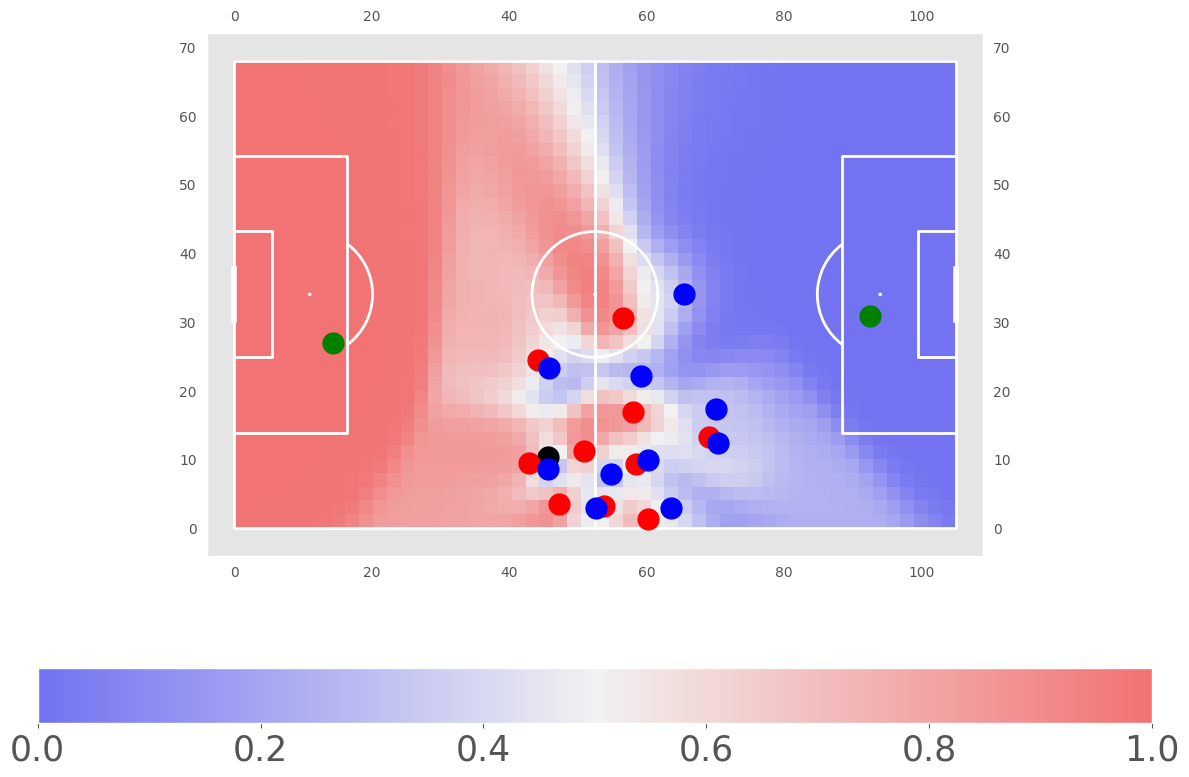

In [97]:
PPCFa, ax, event_df, xgrid, ygrid = calculate_model_pitch_control(melted_df, event_id=125)
# fig, ax = plot_pitchcontrol(event_id=event_id, PPCF=PPCFa, locs=event_df)

In [ ]:
def sum_pitch_control_in_ball_radius(PPCFa, event_row, xgrid, ygrid, radius_m=4.0):
    """
    공의 위치를 중심으로 특정 반경(radius_m) 내의 피치 컨트롤 값을 합산합니다.

    Parameters
    ----------
    PPCFa : np.ndarray
        generate_pitch_control_for_event 함수에서 반환된 2D 피치 컨트롤 배열입니다.
        (일반적으로 (y, x) 또는 (rows, cols) 순서입니다.)
    event_row : pd.Series
        공의 'ballx' (x좌표)와 'bally' (y좌표)를 포함하는 단일 이벤트 행입니다.
    xgrid : np.ndarray
        PPCFa의 x축 격자 중심 좌표 배열입니다. (예: 0.5, 1.5, ..., 104.5)
    ygrid : np.ndarray
        PPCFa의 y축 격자 중심 좌표 배열입니다. (예: 0.5, 1.5, ..., 67.5)
    radius_m : float, optional
        피치 컨트롤 값을 합산할 공 주변의 반경(미터)입니다. 기본값은 4.0m입니다.

    Returns
    -------
    float
        지정된 반경 내에 있는 모든 유효한 격자 셀의 피치 컨트롤 값 합계입니다.
        해당 반경 내에 유효한 셀이 없거나 피치 컨트롤 값이 NaN이면 0.0을 반환합니다.
    """
    # 1. 공의 현재 필드 좌표를 가져옵니다.
    ball_x_m = event_row['ballx']
    ball_y_m = event_row['bally']

    # 2. 격자 셀의 폭과 높이를 계산합니다.
    # xgrid와 ygrid는 각 셀의 중심 좌표를 담고 있으며, 인접한 두 점의 차이가 셀의 크기입니다.
    cell_width = xgrid[1] - xgrid[0]
    cell_height = ygrid[1] - ygrid[0]

    # 3. 공 위치에 가장 가까운 격자 셀의 인덱스를 찾습니다.
    # np.argmin은 배열에서 최소값의 인덱스를 반환하여 가장 가까운 격자 중심을 찾아냅니다.
    ball_grid_x_idx = np.argmin(np.abs(xgrid - ball_x_m))
    ball_grid_y_idx = np.argmin(np.abs(ygrid - ball_y_m))

    # 4. 합산 반경(radius_m)을 격자 셀 단위의 범위로 변환합니다.
    # 반경을 셀 크기로 나눈 후 올림하여, 반경 내에 있는 모든 셀을 포함하도록 합니다.
    radius_cells_x = int(np.ceil(radius_m / cell_width))
    radius_cells_y = int(np.ceil(radius_m / cell_height))

    # 5. 합산할 격자 셀의 인덱스 범위를 설정합니다.
    # 필드 경계를 벗어나지 않도록 max(0, ...) 및 min(..., PPCFa.shape[...] - 1)를 사용합니다.
    min_x_idx = max(0, ball_grid_x_idx - radius_cells_x)
    max_x_idx = min(PPCFa.shape[1] - 1, ball_grid_x_idx + radius_cells_x) # PPCFa.shape[1]은 x축 셀 개수
    min_y_idx = max(0, ball_grid_y_idx - radius_cells_y)
    max_y_idx = min(PPCFa.shape[0] - 1, ball_grid_y_idx + radius_cells_y) # PPCFa.shape[0]은 y축 셀 개수
    
    # 6. 피치 컨트롤 값 합산을 위한 변수를 초기화합니다.
    summed_pitch_control = 0.0

    # 7. 설정된 인덱스 범위 내의 모든 셀을 반복하며 값을 합산합니다.
    # PPCFa 배열은 일반적으로 (rows, cols) 즉 (y, x) 순서이므로, y_idx가 먼저 옵니다.
    for y_idx in range(min_y_idx, max_y_idx + 1):
        for x_idx in range(min_x_idx, max_x_idx + 1):
            # 8. 각 셀의 중심이 실제 지정된 반경 내에 있는지 유클리드 거리를 통해 정밀하게 확인합니다.
            # 이는 정사각형 격자에서 원형 반경을 정확히 근사하기 위함입니다.
            cell_center_x = xgrid[x_idx]
            cell_center_y = ygrid[y_idx]
            
            # 셀 중심과 공 위치 간의 유클리드 거리 계산 (피타고라스 정리)
            distance_to_ball = np.sqrt((cell_center_x - ball_x_m)**2 + (cell_center_y - ball_y_m)**2)
            
            # 거리가 반경(radius_m) 이내인 셀만 합산합니다.
            if distance_to_ball <= radius_m:
                # 유효한 피치 컨트롤 값만 합산합니다 (NaN 값은 건너뜁니다).
                if not np.isnan(PPCFa[y_idx, x_idx]):
                    summed_pitch_control += PPCFa[y_idx, x_idx]
    
    return summed_pitch_control

In [ ]:
sum_pc_4m_radius = sum_pitch_control_in_ball_radius(
    PPCFa,
    event_df.iloc[0], # 공의 위치 정보를 담고 있는 이벤트 행
    xgrid,
    ygrid,
    radius_m = 4.0 # 
)
sum_pc_4m_radius

6.53138771921713